In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
current_dir = '/content/drive/MyDrive/Apziva/MonReader/'

In [3]:
data_dir =current_dir + 'data_unchanged/images'

In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd

#datetime
import datetime

#tensorflow packages
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

#keras layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix



import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

#working with paths
import pathlib

https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance

In [5]:
print(tf.__version__)

2.9.2


In [6]:
train_folder = data_dir + '/training/'

In [7]:
print(train_folder)

/content/drive/MyDrive/Apziva/MonReader/data_unchanged/images/training/


In [8]:
train_data_dir = pathlib.Path(train_folder)

In [9]:
train_data_dir

PosixPath('/content/drive/MyDrive/Apziva/MonReader/data_unchanged/images/training')

In [10]:
train_image_count = len(list(train_data_dir.glob('notflip/*')))
print(train_image_count)

1230


In [11]:
batch_size = 32
img_height = 180
img_width = 180

# Create Validation Subset from the Training Samples

In [12]:
train_data_dir

PosixPath('/content/drive/MyDrive/Apziva/MonReader/data_unchanged/images/training')

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 478 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['flip', 'notflip']


It automatically finds the class names

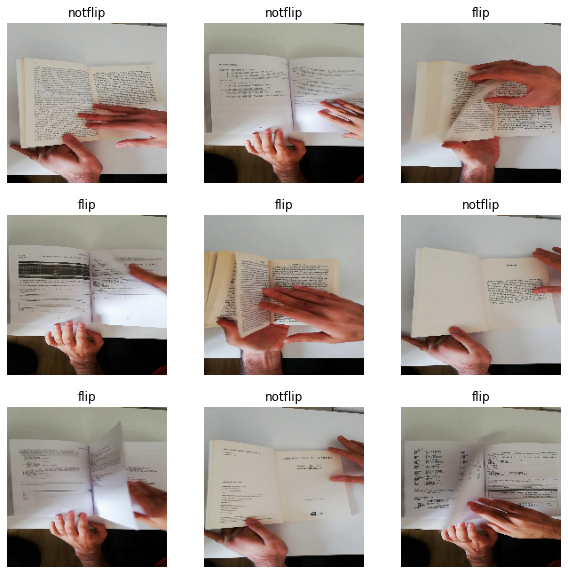

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Normalization Layer/Normalize the image pixels

In [17]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

In [18]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.


Dataset.prefetch overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training

In [20]:
%load_ext tensorboard

# CNN architecture

In [21]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Build f-1 score metric


In [22]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[f1_metric])

In [24]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
60/60 [==============================] - 181s 3s/step - loss: 0.7084 - f1_metric: 0.1881 - val_loss: 0.6871 - val_f1_metric: 0.8177
Epoch 2/3
60/60 [==============================] - 2s 26ms/step - loss: 0.4549 - f1_metric: 0.8103 - val_loss: 0.3768 - val_f1_metric: 0.8883
Epoch 3/3
60/60 [==============================] - 2s 26ms/step - loss: 0.2424 - f1_metric: 0.8730 - val_loss: 0.3080 - val_f1_metric: 0.9118


In [30]:
test_folder = data_dir + '/testing/'

In [31]:
test_dir = pathlib.Path(test_folder)

In [32]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 597 files belonging to 2 classes.


In [33]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate
19/19 [==============================] - 96s 3s/step - loss: 0.3195 - f1_metric: 0.9158


{'loss': 0.31948593258857727, 'f1_metric': 0.915799617767334}

In [34]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
19/19 [==============================] - 3s 76ms/step - loss: 0.3195 - f1_metric: 0.9165
test loss, test acc: [0.31948593258857727, 0.9164660573005676]
